In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from typing import Optional

preprocessed_dir = Path("preprocessed")

global_map = np.load(preprocessed_dir / "global_map.npy", mmap_mode="r")

In [3]:
global_map.shape

(369954202, 3)

In [ ]:
dx = np.diff(np.sort(global_map[:, 0]))
dy = np.diff(np.sort(global_map[:, 1]))
avg_dx = np.mean(dx[dx > 0])  # exclude zeros from duplicate coordinates
avg_dy = np.mean(dy[dy > 0])
print(f"Average distance in x: {avg_dx:.4f}")
print(f"Average distance in y: {avg_dy:.4f}")


Average distance in x: 0.0312
Average distance in y: 0.5000


Text(0.5, 1.0, 'Global Map Visualization')

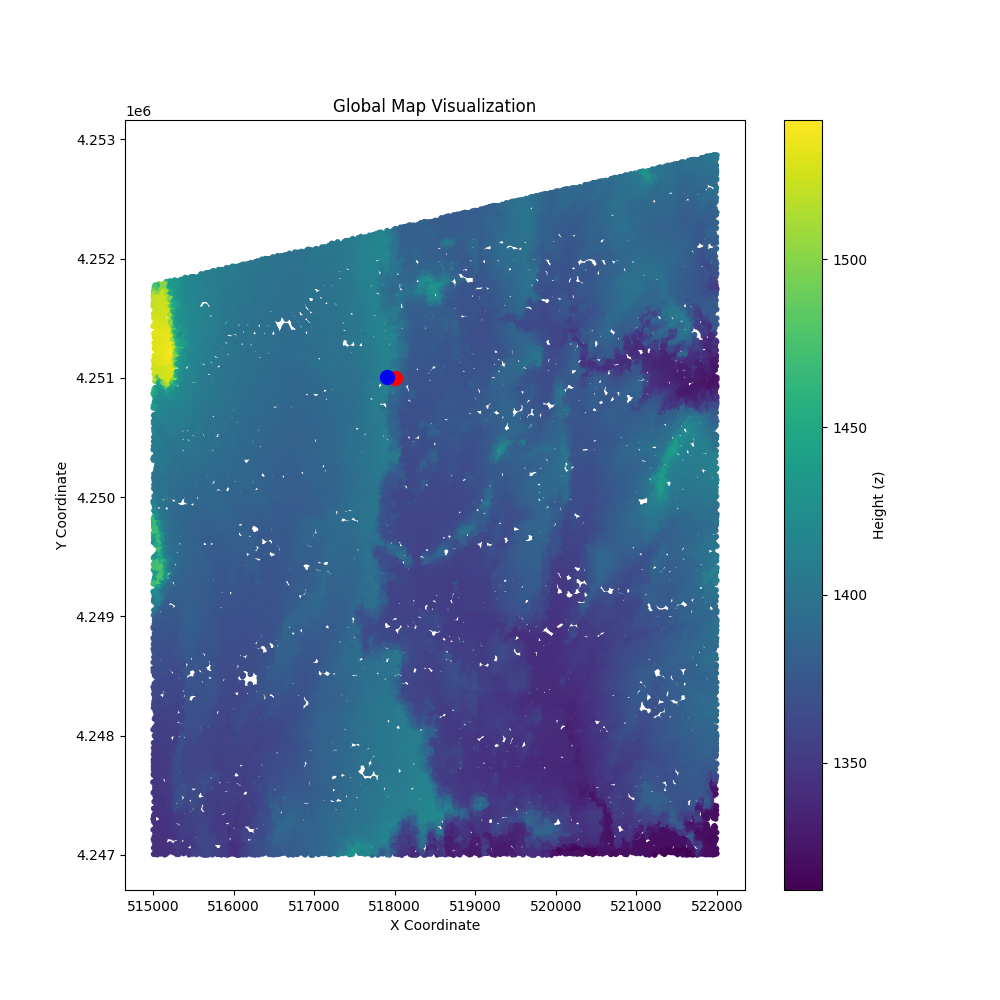

In [ ]:
import matplotlib.pyplot as plt

x = global_map[:, 0][::5000]
y = global_map[:, 1][::5000]
z = global_map[:, 2][::5000]

start_point = np.array([518000, 4251000, 1450])
end_point = np.array([517910, 4251010, 1450])

plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=z, cmap='viridis', s=10)
plt.colorbar(label='Height (z)')
plt.scatter(start_point[0], start_point[1], c='red', s=100, label='Start Point')
plt.scatter(end_point[0], end_point[1], c='blue', s=100, label='End Point')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Global Map Visualization')

In [ ]:
cell_size = 100
index_path = preprocessed_dir / f"spatial_index_{cell_size:.1f}m.npz"

_packed_dtype = np.dtype([("ix", "<i4"), ("iy", "<i4")])

def _pack_coords(ix: np.ndarray, iy: np.ndarray) -> np.ndarray:
    data = np.empty(ix.shape[0], dtype=_packed_dtype)
    data["ix"] = ix
    data["iy"] = iy
    return data.view(np.int64)

def _pack_single(ix: int, iy: int) -> int:
    data = np.empty(1, dtype=_packed_dtype)
    data["ix"] = ix
    data["iy"] = iy
    return int(data.view(np.int64)[0])

def _build_lookup(cell_coords: np.ndarray) -> dict:
    packed = _pack_coords(cell_coords[:, 0], cell_coords[:, 1])
    return {int(key): int(i) for i, key in enumerate(packed)}

def build_spatial_index(points: np.ndarray, cell_size: float) -> dict:
    xy = np.floor(points[:, :2] / cell_size).astype(np.int32)
    order = np.lexsort((xy[:, 1], xy[:, 0]))
    order_dtype = np.uint32 if points.shape[0] < np.iinfo(np.uint32).max else np.int64
    order = order.astype(order_dtype, copy=False)
    sorted_xy = xy[order]
    if sorted_xy.size == 0:
        raise ValueError("No points provided for spatial index")
    diff = np.any(np.diff(sorted_xy, axis=0), axis=1)
    boundaries = np.flatnonzero(diff) + 1
    boundaries = np.concatenate(([0], boundaries, [sorted_xy.shape[0]]))
    cell_offsets = boundaries[:-1].astype(np.int64)
    cell_counts = np.diff(boundaries).astype(np.int32)
    cell_coords = sorted_xy[cell_offsets].astype(np.int32)
    lookup = _build_lookup(cell_coords)
    del xy, sorted_xy
    index = {
        "cell_size": float(cell_size),
        "order": order,
        "cell_coords": cell_coords,
        "cell_offsets": cell_offsets,
        "cell_counts": cell_counts,
        "lookup": lookup,
    }
    return index

def save_spatial_index(index: dict, path: Path) -> None:
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        path,
        cell_size=index["cell_size"],
        order=index["order"],
        cell_coords=index["cell_coords"],
        cell_offsets=index["cell_offsets"],
        cell_counts=index["cell_counts"],
    )

def load_spatial_index(path: Path) -> dict:
    path = Path(path)
    data = np.load(path, allow_pickle=False)
    index = {
        "cell_size": float(data["cell_size"]),
        "order": data["order"],
        "cell_coords": data["cell_coords"],
        "cell_offsets": data["cell_offsets"],
        "cell_counts": data["cell_counts"],
    }
    index["lookup"] = _build_lookup(index["cell_coords"])
    return index

def get_or_build_index(points: np.ndarray, cell_size: float, path: Path) -> dict:
    path = Path(path)
    if path.exists():
        return load_spatial_index(path)
    index = build_spatial_index(points, cell_size)
    save_spatial_index(index, path)
    return index

spatial_index = get_or_build_index(global_map, cell_size, index_path)

def find_points_within_radius(
    center: np.ndarray,
    radius: float,
    points: np.ndarray = global_map,
    index: dict = spatial_index,
    cell_size: Optional[float] = None,
) -> np.ndarray:
    if cell_size is None:
        cell_size = index["cell_size"]
    center = np.asarray(center, dtype=np.float64)
    base = np.floor(center / cell_size).astype(np.int32)
    candidates = []
    radius_sq = float(radius) * float(radius)
    order = index["order"]
    offsets = index["cell_offsets"]
    counts = index["cell_counts"]
    lookup = index["lookup"]
    for dx in (-1, 0, 1):
        for dy in (-1, 0, 1):
            key = _pack_single(int(base[0] + dx), int(base[1] + dy))
            bucket = lookup.get(key)
            if bucket is None:
                continue
            start = offsets[bucket]
            end = start + counts[bucket]
            chunk = points[order[start:end]]
            diff = chunk[:, :2] - center
            mask = (diff[:, 0] ** 2 + diff[:, 1] ** 2) <= radius_sq
            if np.any(mask):
                candidates.append(chunk[mask])
    if candidates:
        return np.vstack(candidates)
    return np.empty((0, points.shape[1]), dtype=points.dtype)

In [ ]:
# A* pathfinding over the point cloud
from heapq import heappush, heappop
from itertools import count

radius = 1
n = 2400
alpha = 1e-5

def distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return float(np.linalg.norm(p1 - p2))

def g_cost(p1: np.ndarray, p2: np.ndarray, n:float=6) -> float:
    # z = sqrt((x2 - x1)^2 + (y2 - y1)^2 + (z2 - z1)^n)
    #print((p2[2] - p1[2]) ** n)
    #return float(np.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2 + (p2[2] - p1[2]) ** n))
    return float((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2 + (p2[2] - p1[2]) ** n)
    #return distance(p1, p2)

def nearest_point(point: np.ndarray, search_radius: float) -> np.ndarray:
    candidates = find_points_within_radius(point[:2], search_radius)
    if candidates.size == 0:
        raise ValueError("No nearby points found; increase radius or choose a different point")
    idx = int(np.argmin(np.linalg.norm(candidates - point, axis=1)))
    return candidates[idx].copy()

def astar(start: np.ndarray, goal: np.ndarray, node_radius: float) -> tuple[np.ndarray, float]:
    start_key = tuple(start.tolist())
    goal_key = tuple(goal.tolist())
    open_heap: list[tuple[float, int, np.ndarray]] = []
    push_index = count()
    heappush(open_heap, (distance(start, goal), next(push_index), start.copy()))
    came_from: dict[tuple[float, float, float], tuple[float, float, float]] = {}
    g_costs: dict[tuple[float, float, float], float] = {start_key: 0.0}
    closed: set[tuple[float, float, float]] = set()
    while open_heap:
        current_f, _, current = heappop(open_heap)
        current_key = tuple(current.tolist())
        if current_key in closed:
            continue
        closed.add(current_key)
        if np.allclose(current, goal):
            path_keys = [current_key]
            while path_keys[-1] != start_key:
                path_keys.append(came_from[path_keys[-1]])
            path_keys.reverse()
            path = np.array(path_keys, dtype=np.float64)
            return path, g_costs[current_key]
        neighbors = find_points_within_radius(current[:2], node_radius)
        if neighbors.size == 0:
            continue
        for neighbor in neighbors:
            if np.allclose(neighbor, current):
                continue
            neighbor_key = tuple(neighbor.tolist())
            tentative_g = g_costs[current_key] + g_cost(current, neighbor, n=n)
            if tentative_g >= g_costs.get(neighbor_key, np.inf):
                continue
            came_from[neighbor_key] = current_key
            g_costs[neighbor_key] = tentative_g
            f_score = tentative_g + alpha*distance(neighbor, goal)
            heappush(open_heap, (f_score, next(push_index), neighbor.copy()))
    raise ValueError("Goal not reachable with current parameters")


In [ ]:
MDRS_base = np.array([519000, 4251000, 1380]) # TODO: Find actual MDRS base coordinates

start_point = MDRS_base + np.array([35, 0, 0])
end_point = MDRS_base + np.array([40, 0, 0])

start_node = nearest_point(start_point, radius)
goal_node = nearest_point(end_point, radius)
path_points, path_cost = astar(start_node, goal_node, radius)
distance(start_point, end_point)

5.0

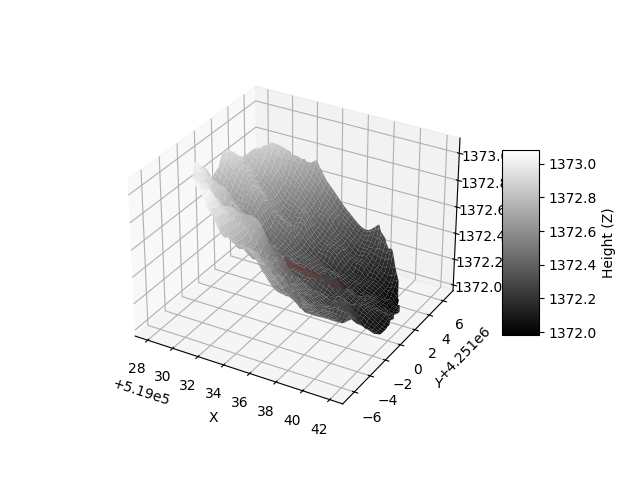

In [ ]:
from scipy.interpolate import griddata

local_map = find_points_within_radius(start_point[:2], distance(start_point, end_point)*1.4)

# Create 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = local_map[:, 0]
y = local_map[:, 1]
z = local_map[:, 2]

grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Scatter plot (your point cloud)
#ax.plot_surface(local_map[:, 0], local_map[:, 1], local_map[:, 2], c='gray')



surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='gray', linewidth=0, antialiased=True)
ax.plot(path_points[:, 0], path_points[:, 1], path_points[:, 2], c='red', linewidth=3, label='Path')


# Optional: add colorbar
fig.colorbar(surf, shrink=0.5, aspect=5, label='Height (Z)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()